In [110]:
import pandas as pd
from gwdistributions import parse, generators
import json
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import re
from tqdm import tqdm
import importlib
import inspect
from scipy.special import erf
import sys

def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


# Hardcoded file path
filename = "population-1.0.csv.gz"

# Read and print the table
df = pd.read_csv(filename, compression='gzip')
df.keys()


Index(['Ncomp', 'Ho', 'OmegaMatter', 'OmegaRadiation', 'OmegaLambda',
       'pow_redshift', 'max_redshift', 'min_redshift', 'min_mass1_source',
       'alpha0', 'break1_mass1_source', 'alpha1', 'max_mass1_source',
       'highpass_mass_scale', 'highpass_exponent', 'lowpass_mass_scale',
       'lowpass_exponent', 'notch_amplitude', 'notch_lowmass_scale',
       'notch_lowmass_exponent', 'notch_highmass_scale',
       'notch_highmass_exponent', 'sumgaussianpeak_prefactor_mass1_source_0',
       'sumgaussianpeak_mean_mass1_source_0',
       'sumgaussianpeak_stdv_mass1_source_0',
       'sumgaussianpeak_prefactor_mass1_source_1',
       'sumgaussianpeak_mean_mass1_source_1',
       'sumgaussianpeak_stdv_mass1_source_1', 'pairing_pow_q_low',
       'pairing_pow_q_high', 'pairing_mbreak',
       'min_spin1_magnitude_mass1_source_0',
       'max_spin1_magnitude_mass1_source_0',
       'mean_spin1_magnitude_mass1_source_0',
       'stdv_spin1_magnitude_mass1_source_0', 'switch_mass1_source_0'

In [111]:
df["mean_spin2_cos_polar_angle_spin2_polar_angle_1_mass2_source_0"]

0      -1.0
1      -1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
4995   -1.0
4996   -1.0
4997   -1.0
4998   -1.0
4999   -1.0
Name: mean_spin2_cos_polar_angle_spin2_polar_angle_1_mass2_source_0, Length: 5000, dtype: float64

In [112]:
parse_file = parse.parse_config("multiPDB_betaSplit_brokenG.ini")
EG = generators.EventGenerator(*parse_file)

/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))


In [113]:
converted_posterior_samples = df.to_dict(orient="list")
# read ../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt as dict file 
import ast
import numpy as np
with open("../conversion_dictionaries/multiPDB_betaSplit_brokenG.txt", "r") as f:
    conversion_dict = ast.literal_eval(f.read())

samples = []
num_hyperparams = len(conversion_dict)
num_samples = len(converted_posterior_samples["notch_amplitude"])

for i in range(num_samples):
    sample_dict = {}
    for key, value in converted_posterior_samples.items():
        sample_dict[key] = value[i]
    samples.append(sample_dict)
assert len(samples) == num_samples, f"Expected 5000 samples, but got {len(samples)}"
assert len(samples[0]) == num_hyperparams, f"Expected each dictionary to have {num_hyperparams} keys, but got {len(samples[0])}"


In [114]:
cosmo_params = ["OmegaMatter", "Ho", "OmegaRadiation", "OmegaLambda"]
redshift_lims = ["min_redshift", "max_redshift"]
known_exceptions = [*cosmo_params, *redshift_lims]

mass_dist2d = EG.variate2distribution("mass1_source")
mass_dist1d = mass_dist2d.massdist
prob_mass = []
prob_joint_mass = []


mag_dist = EG.variate2distribution("spin1_magnitude")
mag_NS = []
mag_BH = []

tilt_dist = EG.variate2distribution("spin1_polar_angle")
tilt_NS = []
tilt_BH = []

for s in tqdm(samples[:100]):
    EG.update(**s)
    lst = list(EG.parameters.keys())
    lst = [param for param in lst if param != 'Ncomp']

    # print("-----------------")
    # print(EG.parameters["notch_highmass_scale"])

    for item in lst:
        if item in known_exceptions:
            continue
        assert EG[item] == s[item], f"Mismatch for {item}: {EG[item]} vs {s[item]}"

    # Mass distribution
    mass_grid = np.logspace(0, 2, 1000)
    p_m = mass_dist1d.prob(mass_grid)
    p_m = p_m / np.sum(p_m)  # Normalize the distribution
    prob_mass.append(p_m)

    # Joint mass distribution
    joint_mass_grid = np.logspace(0, 2, 100)
    mjoint_grid = cartesian([joint_mass_grid, joint_mass_grid])
    p_m1_m2 = mass_dist2d.prob(mjoint_grid.T[0], mjoint_grid.T[1])
    p_m1_m2 = p_m1_m2 / np.sum(p_m1_m2)  # Normalize the distribution
    prob_joint_mass.append(p_m1_m2)

    # Spin Magnitude distribution
    mag_grid = np.linspace(0, 1, 1000)
    p_mag_NS = mag_dist.prob(mag_grid, 1.4)
    p_mag_BH = mag_dist.prob(mag_grid, 10)
    p_mag_NS = p_mag_NS / np.sum(p_mag_NS)  # Normalize the distribution
    p_mag_BH = p_mag_BH / np.sum(p_mag_BH)  # Normalize the distribution
    mag_NS.append(p_mag_NS)
    mag_BH.append(p_mag_BH)

    # Spin Tilt distribution
    tilt_grid = np.linspace(-1, 1, 1000)
    # print(tilt_dist.params)
    # print(tilt_dist.prob(0.3, 5))
    p_tilt_NS = tilt_dist.prob(tilt_grid, 1.4) # For lower massses
    p_tilt_BH = tilt_dist.prob(tilt_grid, 10) # For higher masses
    p_tilt_NS = p_tilt_NS / np.sum(p_tilt_NS)  # Normalize the distribution
    p_tilt_BH = p_tilt_BH / np.sum(p_tilt_BH)  # Normalize the distribution
    tilt_NS.append(p_tilt_NS)
    tilt_BH.append(p_tilt_BH)

prob_mass = np.array(prob_mass)
prob_joint_mass = np.array(prob_joint_mass)
p_mag_NS = np.array(mag_NS)
p_mag_BH = np.array(mag_BH)

  0%|          | 0/100 [00:00<?, ?it/s]/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/utils/cosmology.py:178: RuntimeWarning: divide by zero encountered in log
  return be.log(4*be.pi) + 2*be.log(Dc) + be.log(self.dDcdz(z))
/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/distributions/spin/polar.py:140: RuntimeWarning: divide by zero encountered in log
  return Uniform._logprob(be.cos(pole), -1, +1) + be.log(be.clip(be.sin(pole), 0, 1))
/fs/lustre/scratch/mali/.venv/lib64/python3.11/site-packages/gwdistributions/distributions/base/mixture.py:167: RuntimeWarning: divide by zero encountered in log
  return be.log(prob)
100%|██████████| 100/100 [00:12<00:00,  8.07it/s]


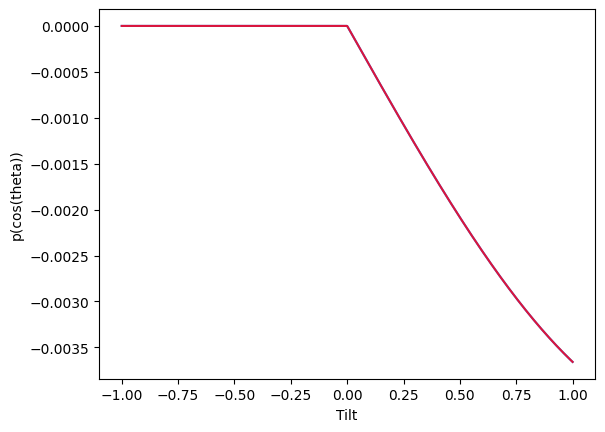

In [115]:
plt.figure()
p50 = np.cos(np.percentile(tilt_NS, 50, axis=0)) * -np.sin(np.percentile(tilt_NS, 50, axis=0))
# p95 = np.percentile(tilt_NS, 95, axis=0)
# p5 = np.percentile(tilt_NS, 5, axis=0)
# plt.fill_between(tilt_grid, p5, p95, facecolor="lightblue", alpha=1)
plt.plot(tilt_grid, p50.squeeze(), color="dodgerblue")
p50 = np.cos(np.percentile(tilt_BH, 50, axis=0)) * -np.sin(np.percentile(tilt_BH, 50, axis=0))
# p95 = np.percentile(tilt_BH, 95, axis=0)
# p5 = np.percentile(tilt_BH, 5, axis=0)
# plt.fill_between(tilt_grid, p5, p95, facecolor="crimson", alpha=0.5)
plt.plot(tilt_grid, p50.squeeze(), color="crimson")
plt.xlabel("Tilt") ; plt.ylabel("p(cos(theta))")
plt.show()